In [1]:
import torch
import torch.nn as nn
from base.data import get_data_loaders, get_data_loaders_wandb
from base.train import Trainer, eval_metrics

In [2]:
class MLPHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_norm, dropout, n_layers):
        super(MLPHead, self).__init__()
        l_sz = [in_dim] + [in_dim//2**(i+1) for i in range(n_layers)] + [out_dim]
        layers = []
        for i in range(1, len(l_sz)-1):
            layers.append(nn.Linear(l_sz[i-1], l_sz[i]))
            if use_norm == 'batch':
                layers.append(nn.BatchNorm1d(l_sz[i]))
            elif use_norm == 'layer':
                layers.append(nn.LayerNorm(l_sz[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(l_sz[-2], l_sz[-1]))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        return self.head(x)

In [3]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_embeddings = cfg['n_embeddings']
        self.projection = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_latent_dim']),
            nn.LayerNorm(cfg['emb_latent_dim'])
        )
        # in_dim = cfg['emb_latent_dim'] * self.n_embeddings + cfg['transf_dim']
        in_dim = cfg['emb_latent_dim'] * (self.n_embeddings[0] + self.n_embeddings[1]) + cfg['transf_dim']
        out_dim = 1 if cfg['task'] == 'regression' else cfg['num_classes']
        self.head = MLPHead(in_dim, out_dim, cfg['use_layer_norm'], cfg['dropout'], cfg['n_hid_layers'])

    # (EMB1, TRANSF) (case 1)
    # (EMB1, EMB2, TRANSF) (case 2)
    def forward(self, batch):
        if self.n_embeddings[0]:
            em_feat_1 = self.projection(batch[0])
            if self.n_embeddings[1] == True:
                em_feat_2 = self.projection(batch[1])
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_1, em_feat_2, batch[2]], dim=1)
                else:
                    x = torch.cat([em_feat_1, em_feat_2], dim=1)
            else:
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_1, batch[1]], dim=1)
                else:
                    x = em_feat_1
        else:
            if self.n_embeddings[1]:
                em_feat_2 = self.projection(batch[0])
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_2, batch[1]], dim=1)
                else:
                    x = em_feat_2
        return self.head(x).squeeze(-1)

        # em_feat_1 = self.projection(batch[0])
        # if self.n_embeddings == 1:
        #     x = torch.cat([em_feat_1, batch[1]], dim=1)
        # elif self.n_embeddings == 2:
        #     em_feat_2 = self.projection(batch[1])
        #     x = torch.cat([em_feat_1, em_feat_2, batch[2]], dim=1)
        # return self.head(x).squeeze(-1)

In [ ]:
cfg_data = {
    'n_workers': 32,
    'batch_size': 2048,    
    'stratification': 'majority', # 'random', 'binary', 'clustered', 'majority'
    'data_path': '/mnt/fastdata/datasets/lore-loops/web-clang',
    'embedding_model': 'source_coderankembed', # 'llvm_llmcompiler', 'source_codellama', 'source_llmcompiler', 'source_codet5p', 'source_coderankembed'
    'embedding_layer': 'last', # 'last', 'all' (not working yet)
    'n_embeddings': [1, 0, 1], # binary flags for [ref_embedding, transformation_embedding, transformation_encoding]
    'min_transformations': 1, # only loop groups with at least <min> transformations
    'max_transformations': 10000, # only loop groups with at most <max> transformations
    'max_speedup': 2.5, # remove any loop group with a speedup transformation > max_speedup
    'max_source_size': 100000, # only loop groups where reference .C file is at most <max> bytes
    'task': 'classification',  # 'classification', 'regression'
    # [(0, np.float64(0.5)), (2, np.float64(1.5)), (4, np.float64(2.5)), (6, np.float64(3.5))]
    'class_splits': [0, .7, 1, 1.5, 17],
    # 'class_splits': [-100, .5, 0.9999, 1.0001, 1.5, 2.5, 3.5, 100000],
    'classes': ['HSL', 'SL', 'SP', 'HSP'],
    'seed': 4
}
# tr_loader, va_loader, te_loader = get_data_loaders(cfg_data)
tr_loader, va_loader = get_data_loaders_wandb(cfg_data)

Loop groups stratified into Counter({'SL': 595, 'SP': 525, 'HSL': 416, 'HSP': 51})
Total loop groups: 1587 Train: 1269 Val: 318
768
56
40 loop groups removed for this split
768
56
11 loop groups removed for this split
Total datapoints: 69057 Train: 56372 Valid: 12685


In [ ]:
cfg_model = {
    'n_hid_layers': 3,
    'n_embeddings': cfg_data['n_embeddings'],
    'emb_dim': tr_loader.dataset.embed_dim, # embedding dimensionality
    'emb_latent_dim': 256, # embedding projection dimensionality
    'transf_dim': tr_loader.dataset.tr_dim, # transformation dimensionality
    'model_type': 'mlp', # 'attention', 'mlp'
    'task': cfg_data['task'],
    'dropout': 0.2,
    'learning_rate': 1e-3,
    'use_layer_norm': 'batch',
    'weight_decay': 1e-3,
    'max_epochs': 100,
    'num_classes': len(cfg_data['classes'])
}

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if cfg_model['model_type'] == 'attention':
    model = BidirectionalCrossAttention(cfg_model).to(device)
elif cfg_model['model_type'] == 'mlp':
    model = MLP(cfg_model).to(device)
print(f'Using device: {device}')
print(model)

Using device: cuda:0
MLP(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (head): MLPHead(
    (head): Sequential(
      (0): Linear(in_features=312, out_features=156, bias=True)
      (1): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=156, out_features=78, bias=True)
      (5): BatchNorm1d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=78, out_features=39, bias=True)
      (9): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout(p=0.2, inplace=False)
      (12): Linear(in_features=39, out_features=4, bias=True)
    )
  )
)


In [11]:
model = Trainer(device, model, cfg_model)
tr_losses, va_losses = model.train(tr_loader, va_loader)
model.model.load_state_dict(torch.load('best_model.pth', weights_only=True))

Epoch: 1	Tr Loss: 1.070	Val Loss: 0.871
Epoch: 2	Tr Loss: 0.767	Val Loss: 0.886
Epoch: 3	Tr Loss: 0.594	Val Loss: 0.628
Epoch: 4	Tr Loss: 0.510	Val Loss: 0.651
Epoch: 5	Tr Loss: 0.457	Val Loss: 0.585
Epoch: 6	Tr Loss: 0.419	Val Loss: 0.541
Epoch: 7	Tr Loss: 0.388	Val Loss: 0.528
Epoch: 8	Tr Loss: 0.360	Val Loss: 0.521
Epoch: 9	Tr Loss: 0.339	Val Loss: 0.633
Epoch: 10	Tr Loss: 0.323	Val Loss: 0.530
Epoch: 11	Tr Loss: 0.309	Val Loss: 0.561
Epoch: 12	Tr Loss: 0.301	Val Loss: 0.562
Epoch: 13	Tr Loss: 0.290	Val Loss: 0.515
Epoch: 14	Tr Loss: 0.278	Val Loss: 0.519
Epoch: 15	Tr Loss: 0.270	Val Loss: 0.514
Epoch: 16	Tr Loss: 0.261	Val Loss: 0.514
Epoch: 17	Tr Loss: 0.254	Val Loss: 0.553
Epoch: 18	Tr Loss: 0.251	Val Loss: 0.544
Epoch: 19	Tr Loss: 0.245	Val Loss: 0.583
Epoch: 20	Tr Loss: 0.242	Val Loss: 0.567
Early stopping triggered after 20 epochs.


<All keys matched successfully>

Accuracy (4-way): 0.9145
Accuracy (speedup/slowdown): 0.9925


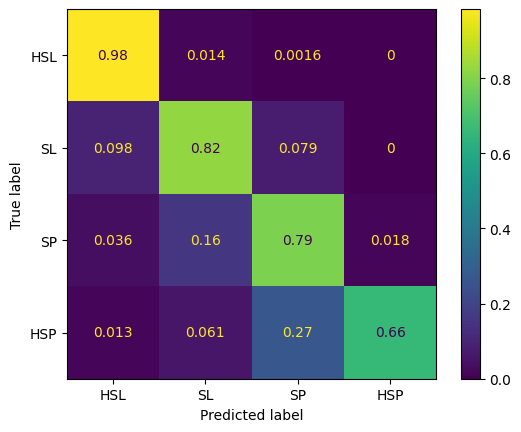

In [14]:
preds, tgts = model.predict(tr_loader)
mapping = tr_loader.dataset.loop_mapping if cfg_data['min_transformations'] > 2 else None
eval_metrics(preds, tgts, figures=True, mapping=mapping, type=cfg_data['task'], classes=cfg_data['classes'])

Accuracy (4-way): 0.8184
Accuracy (speedup/slowdown): 0.9923


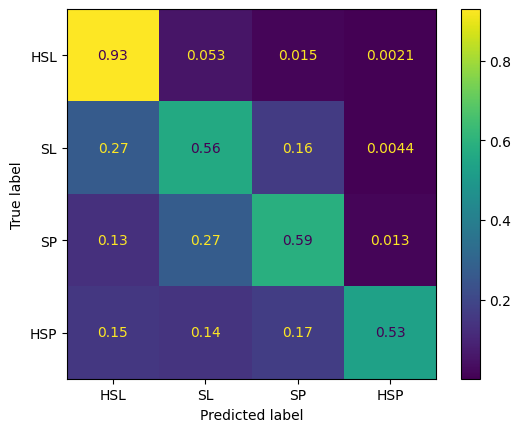

In [15]:
# 1 0 1: 0.76, 0.87
# 0 1 1: 0.75, 0.86
# 1 1 1: 0.76, 0.87
preds, tgts = model.predict(va_loader)
mapping = va_loader.dataset.loop_mapping if cfg_data['min_transformations'] > 2 else None
eval_metrics(preds, tgts, figures=True, mapping=mapping, type=cfg_data['task'], classes=cfg_data['classes'])

In [ ]:
preds, tgts = model.predict(te_loader)
mapping = te_loader.dataset.loop_mapping if cfg_data['min_transformations'] > 2 else None
eval_metrics(preds, tgts, figures=True, mapping=None, type=cfg_data['task'], classes=cfg_data['classes'])

In [ ]:
k_runs = 5
losses = []
for run_num in range(1, k_runs+1):
    cfg_data['seed'] = run_num
    tr_loader, va_loader = get_data_loaders_wandb(cfg_data)
    model = MLP(cfg_model).to(device)
    model = Trainer(device, model, cfg_model)
    tr_losses, va_losses = model.train(tr_loader, va_loader)
    losses.append({
        "tr_loop_ids": [id['id'] for id in tr_loader.dataset.loop_mapping],
        "va_loop_ids": [id['id'] for id in va_loader.dataset.loop_mapping],
        "tr_losses": tr_losses,
        "va_losses": va_losses
    })

In [ ]:

print(len(losses))
print(losses[0].keys())
print(len(losses[1]['tr_loop_ids']))
print(len(losses[1]['va_loop_ids']))

for run_idx, run in enumerate(losses):
    idx_of_min_loss = run['va_losses'].index(min(run['va_losses']))
    print(f'Run {run_idx+1}\tEpoch: {idx_of_min_loss+1}\ttr_loss: {run['tr_losses'][idx_of_min_loss]}\tva_loss: {run['va_losses'][idx_of_min_loss]}')
    print(f'tr_ids: {run['tr_loop_ids']}')
    print(f'va_ids: {run['va_loop_ids']}')


In [16]:
import matplotlib.pyplot as plt
from collections import Counter
import os

def generate_histograms(datasets, cfg, bins=10):
    plot_dims = (5, 2*len(datasets))
    print(plot_dims)
    title = 'Histogram Plots'
    fig, axes = plt.subplots(plot_dims[0], plot_dims[1], figsize=(plot_dims[1] * 6, plot_dims[0] * 5), subplot_kw={'projection': None})
    fig.suptitle(title, fontsize=16)
    labels = ['Train', 'Validation']

    axes_map = {'speedup': 0,
                'ref_file_size': 1,
                'all_file_size': 2,
                '#_transformations': 3,
                'loop_majority_count': 4,
                }

    for run_idx, run in enumerate(datasets):
        for col, data in enumerate(run):
            # Speedup Histograms
            speedup_counts, speedup_bin_edges, _ = axes[axes_map['speedup'], (run_idx * len(run)) + col].hist(data.Y, bins=bins)
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]} (n={len(data)})')
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_xlabel('Speedup')
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_xticks(speedup_bin_edges)
            axes[axes_map['speedup'], (run_idx * len(run)) + col].set_yticks([5000, 10000, 15000, 20000, 25000])

            for count, edge in zip(speedup_counts, speedup_bin_edges[:-1]):
                axes[axes_map['speedup'], (run_idx * len(run)) + col].text(edge + (speedup_bin_edges[1] - speedup_bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')
                
            ids = [loop_data['id'] for loop_data in data.loop_mapping]

            # Reference File Size Histograms
            ref_file_sizes = []
            for l_id in ids:
                ref_fname = [f for f in os.listdir(os.path.join(cfg['data_path'],l_id)) if f.endswith('c.0.c')][0]
                ref_file_sizes.append(os.path.getsize(os.path.join(cfg['data_path'], l_id, ref_fname)))

            counts, bin_edges, _ = axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].hist(ref_file_sizes, bins=bins)
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]}  (n={len(ref_file_sizes)})')
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_xlabel('Reference File Size (bytes)')
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_xticks([int(e) for e in bin_edges])
            # axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].set_yticks([25, 50, 75, 100, 125, 150, 175, 200])

            for count, edge in zip(counts, bin_edges[:-1]):
                axes[axes_map['ref_file_size'], (run_idx * len(run)) + col].text(edge + (bin_edges[1] - bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')
                
            # All File Size Histograms
            all_file_sizes = []
            for l_id in ids:
                fnames = [f for f in os.listdir(os.path.join(cfg['data_path'],l_id)) if f.endswith('.c')]
                for fname in fnames:
                    all_file_sizes.append(os.path.getsize(os.path.join(cfg['data_path'], l_id, fname)))

            counts, bin_edges, _ = axes[axes_map['all_file_size'], (run_idx * len(run)) + col].hist(all_file_sizes, bins=bins)
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]}  (n={len(all_file_sizes)})')
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_xlabel('File Size (bytes)')
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_xticks([int(e) for e in bin_edges])
            # axes[axes_map['all_file_size'], (run_idx * len(run)) + col].set_yticks([25, 50, 75, 100, 125, 150, 175, 200])

            for count, edge in zip(counts, bin_edges[:-1]):
                axes[axes_map['all_file_size'], (run_idx * len(run)) + col].text(edge + (bin_edges[1] - bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')

            # # Transformations Histograms
            num_transformations = []
            for l_id in ids:
                num_transformations.append(len([f for f in os.listdir(os.path.join(cfg['data_path'],l_id)) if f.endswith('.c')]))

            counts, bin_edges, _ = axes[axes_map['#_transformations'], (run_idx * len(run)) + col].hist(num_transformations, bins=bins)
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]} (n={len(num_transformations)})')
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_xlabel('# Transformations')
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_xticks(bin_edges)
            # axes[axes_map['#_transformations'], (run_idx * len(run)) + col].set_yticks([200, 400, 600, 800, 1000])

            for count, edge in zip(counts, bin_edges[:-1]):
                axes[axes_map['#_transformations'], (run_idx * len(run)) + col].text(edge + (bin_edges[1] - bin_edges[0]) / 2,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')
                
            # Loop Count Majority Class
            loop_classes = []
            for l_id in ids:
                fname = os.path.join(cfg['data_path'], l_id, f'{l_id}_speedup_refs.pt')
                speedups = torch.load(fname, weights_only=True, map_location='cpu')
                loop_id_stats = []
                for i in range(len(cfg['class_splits'])-1):
                    loop_id_stats.append(torch.where((speedups > cfg['class_splits'][i]) & (speedups < cfg['class_splits'][i+1]), 1, 0).sum())
                loop_classes.append(cfg['classes'][loop_id_stats.index(max(loop_id_stats))])

            counts = Counter(loop_classes)
            counts = Counter({key: counts[key] for key in cfg['classes']})
            
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].bar(counts.keys(), counts.values())
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_title(f'Run {run_idx+1} {labels[col]} (n={len(loop_classes)})')
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_xlabel('Majority Class')
            axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_ylabel('Frequency')
            # axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].set_yticks([50, 100, 150, 200, 250, 300, 350])

            for count, edge in zip(counts.values(), counts.keys()):
                axes[axes_map['loop_majority_count'], (run_idx * len(run)) + col].text(edge,
                        count,
                        str(int(count)), 
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    # plt.savefig('plots.png')

(5, 2)


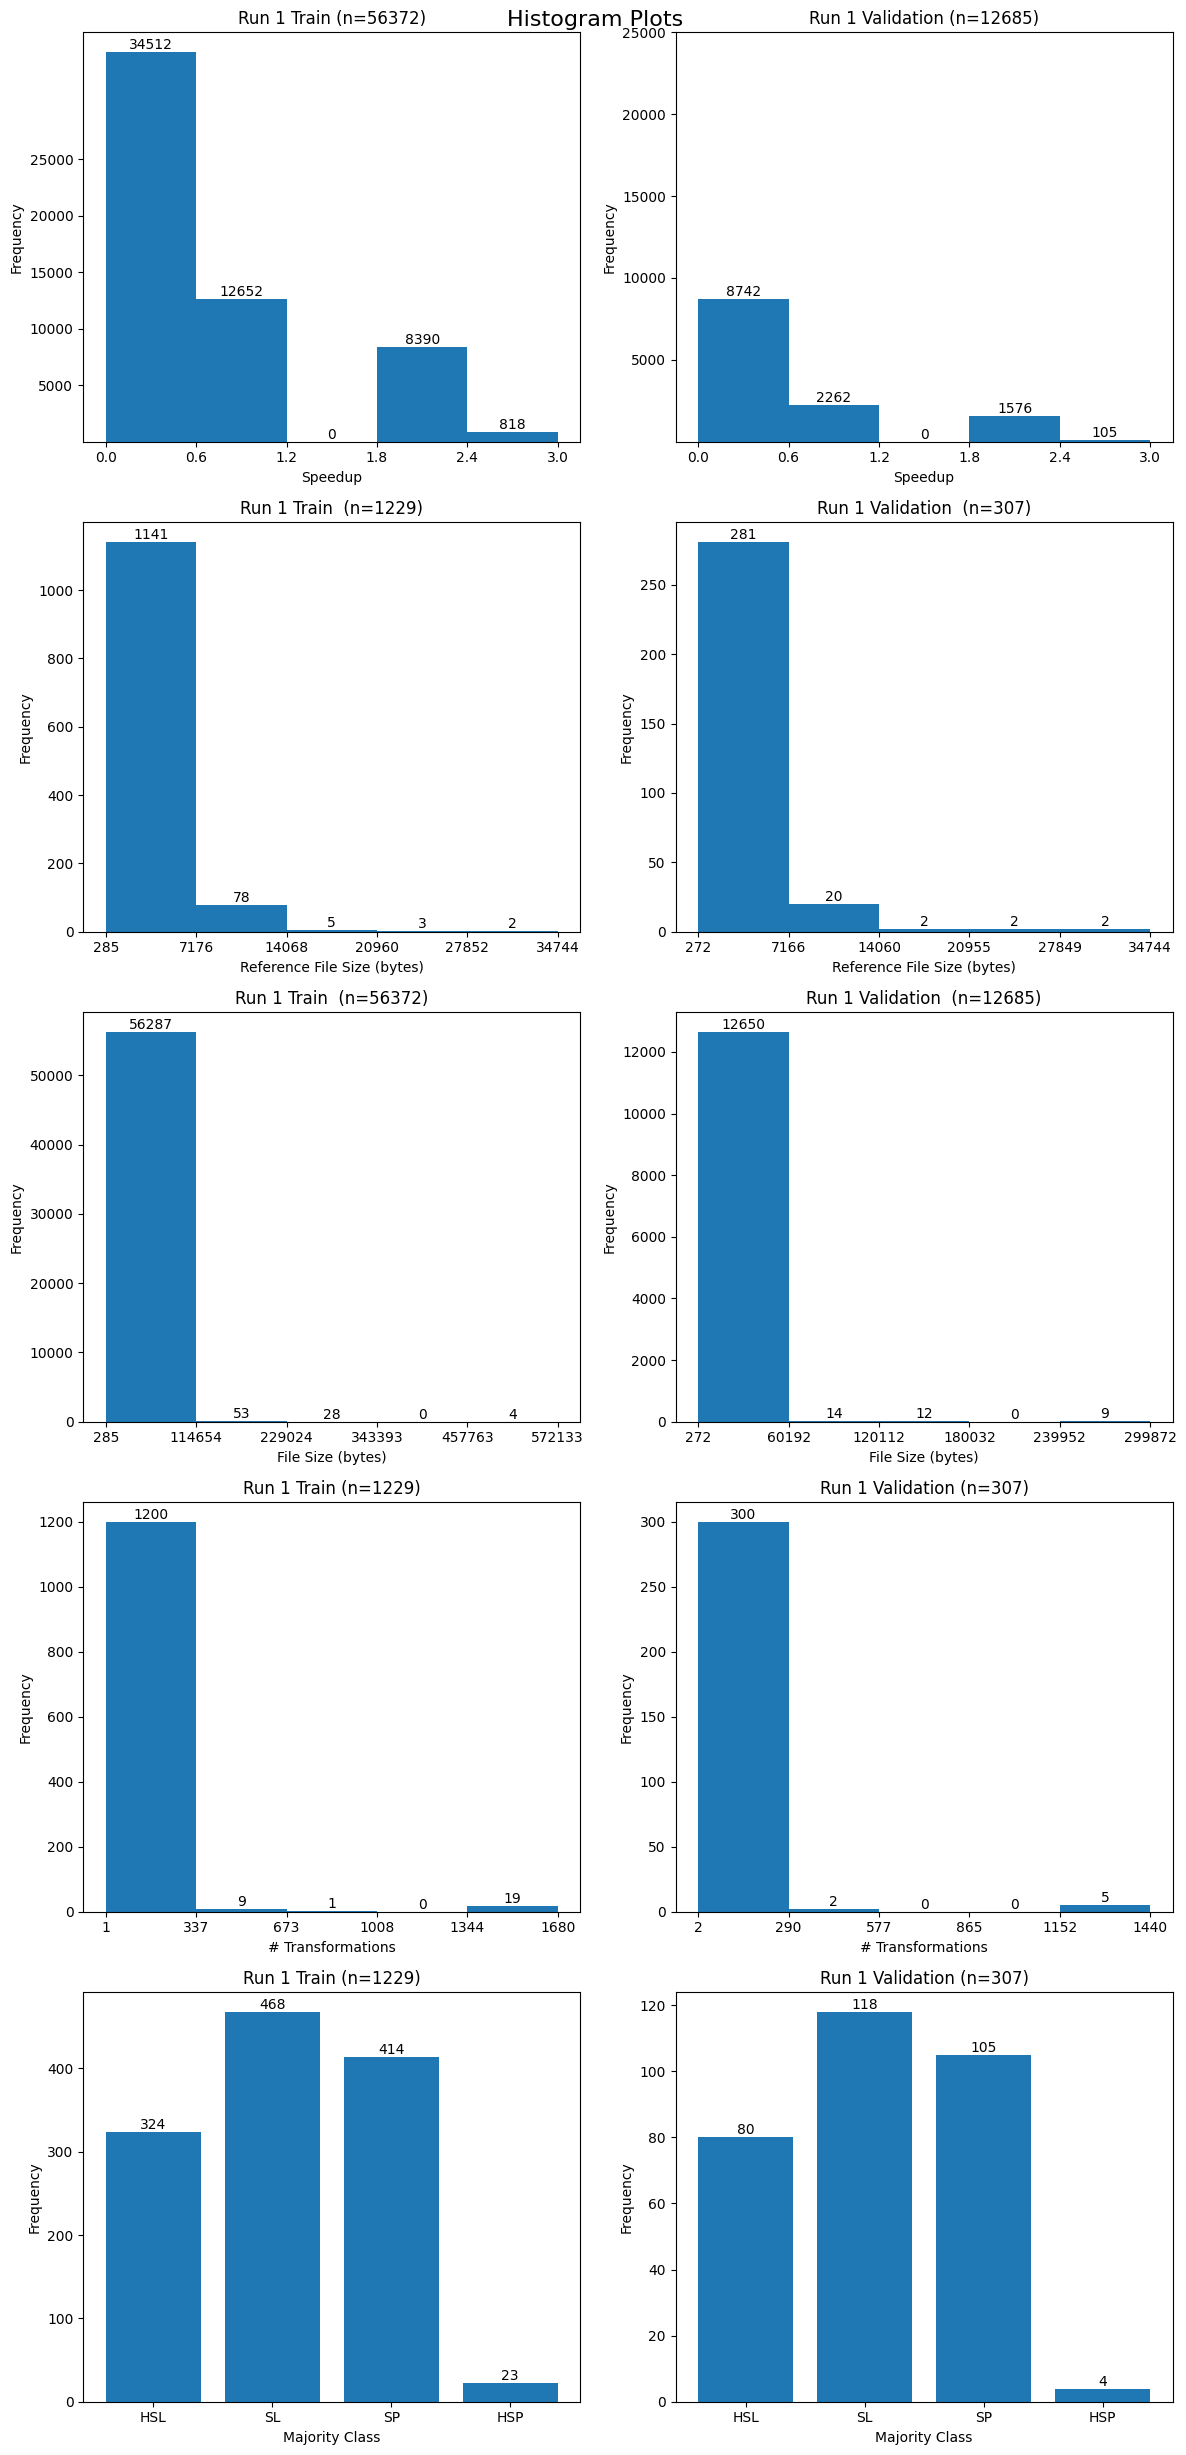

In [17]:
datasets = [[tr_loader.dataset, va_loader.dataset]]
generate_histograms(datasets, cfg_data, bins=5)

In [ ]:
##########################################
# REQUIRES A SECOND LOOK
##########################################
class BidirectionalCrossAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_embeddings = cfg['n_embeddings']
        self.projection = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_latent_dim']),
            nn.LayerNorm(cfg['emb_latent_dim'])
        )
        latent_dim = cfg['emb_latent_dim'] * self.n_embeddings
        out_dim = 1 if cfg['task'] == 'regression' else cfg['num_classes']
        self.head = MLPHead(latent_dim+cfg['transf_dim'], out_dim, cfg['use_layer_norm'], cfg['dropout'], cfg['n_hid_layers'])
        self.cross_attention1 = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, dropout=cfg['dropout'], batch_first=True, kdim=cfg['transf_dim'], vdim=cfg['transf_dim'])
        self.cross_attention2 = nn.MultiheadAttention(embed_dim=cfg['transf_dim'], num_heads=4, dropout=cfg['dropout'], batch_first=True, kdim=latent_dim, vdim=latent_dim)

    def forward(self, batch):
        emb_proj_1 = self.projection(batch[0])
        if self.n_embeddings == 1:
            features1, _ = self.cross_attention1(query=emb_proj_1, key=batch[1], value=batch[1])
            features2, _ = self.cross_attention2(query=batch[1], key=emb_proj_1, value=emb_proj_1)
            return self.head(torch.cat([emb_proj_1+features1, batch[1]+features2], dim=1)).squeeze(-1)
        elif self.n_embeddings == 2:
            emb_proj_2 = self.projection(batch[1])
            embs = torch.cat([emb_proj_1, emb_proj_2], dim=1)
            features1, _ = self.cross_attention1(query=embs, key=batch[2], value=batch[2])
            features2, _ = self.cross_attention2(query=batch[2], key=embs, value=embs)
            return self.head(torch.cat([embs+features1, batch[2]+features2], dim=1)).squeeze(-1)